In [32]:
from os import environ as ENV
from time import time as now
from multiprocessing import Pool
import json
from tqdm.notebook import tqdm

import sys
sys.path.append(ENV['PWD'])

from should_be_stdlib import *
from circuit_postprocess import *
from circuit_extra import *

In [355]:
# get finished jobs
with open(ENV['HOME'] + '/work/jobs.json', 'r+') as f:
    job_ids = {
        k: {
            int(ki): vi
            for ki, vi in v.items()
        }
        for k, v in json.load(f).items()
    }

In [331]:
# login to IBM
from provider_ibmq import IBMQ
ibmq = IBMQ(
    ibm_api_key := open(ENV['HOME'] + '/work/api-keys/IBM_API_KEY').readline().strip(),
    ibm_crn := open(ENV['HOME'] + '/work/api-keys/IBM_CRN').readline().strip()
)

# recover and postprocess jobs

In [4]:
SHOTS = 1000
def get_0_prob(batched_counts):
    # in case of batch of length 1 (first element is not a dictionary), just return counts directly
    if type(list(batched_counts.values())[0]) is not dict:
        return {0: batched_counts.get('0000', 0) / SHOTS}
    else:
        # could compute shots dynamically but we know what the value is since every circuit has the same # of shots
        return {inside_batch_num: counts.get('0000', 0) / SHOTS for inside_batch_num, counts in batched_counts.items()}

In [5]:
# ??? Why no worky
def swap_expectation_wrapper(batched_counts):
    # # print(batched_counts)
    # print(batched_counts[0])
    # new_d = {int(bitstring, 2): count/(2**18) for bitstring, count in batched_counts[0]}
    # print(swap_expectation(new_d))
    # 1/0
    return {
        inside_batch_num:
            swap_expectation({int(bitstring, 2): count/(2**(9*2)) for bitstring, count in counts.items()}, size=9)[1]  # get fidelity not exp value
        for inside_batch_num, counts in batched_counts.items()
    }
    

In [6]:
ang_results = {
    batch_num: swap_expectation_wrapper(ibmq.jobresult(job_id))
    for batch_num, job_id
    in tqdm(job_ids['ang'].items())}

  0%|          | 0/59 [00:00<?, ?it/s]

In [7]:
amp_qft_results = {
    batch_num: get_0_prob(ibmq.jobresult(job_id))
    for batch_num, job_id
    in tqdm(job_ids['amp_qft'].items())}


  0%|          | 0/74 [00:00<?, ?it/s]

In [8]:
amp_qft_ddd_results = {
    batch_num: get_0_prob(ibmq.jobresult(job_id))
    for batch_num, job_id
    in tqdm(job_ids['amp_qft_ddd'].items())}

  0%|          | 0/66 [00:00<?, ?it/s]

In [9]:
amp_results = {
    batch_num: get_0_prob(ibmq.jobresult(job_id))
    for batch_num, job_id
    in tqdm(job_ids['amp'].items())}

  0%|          | 0/63 [00:00<?, ?it/s]

In [10]:
amp_ddd_results = {
    batch_num: get_0_prob(ibmq.jobresult(job_id))
    for batch_num, job_id
    in tqdm(job_ids['amp_ddd'].items())}

  0%|          | 0/70 [00:00<?, ?it/s]

# Save results

In [11]:
import pandas as pd
# read an excel file so we have the right columns to use, jobs are queued in column order
circuit_results_df = pd.read_excel(ENV['PWD'] + '/data/circuits_quantum_fidelity_angle_embed.xlsx', index_col=0).drop(columns='qasm2')

In [12]:
import itertools
def dict_of_dicts_to_list(d):
    return list(itertools.chain(*[v.values() for v in d.values()]))

In [13]:
circuit_results_df['ang'] = dict_of_dicts_to_list(ang_results)
circuit_results_df['amp_qft'] = dict_of_dicts_to_list(amp_qft_results)
circuit_results_df['amp_qft_ddd'] = dict_of_dicts_to_list(amp_qft_ddd_results)
circuit_results_df['amp'] = dict_of_dicts_to_list(amp_results)
circuit_results_df['amp_ddd'] = dict_of_dicts_to_list(amp_ddd_results)

In [17]:
circuit_results_df.to_excel(ENV['PWD'] + '/data/quantum_fidelity_ibm_kingston.xlsx')

In [16]:
circuit_results_df

,A,B,ang,amp_qft,amp_qft_ddd,amp,amp_ddd
0,23,32,0.501373,0.360,0.356,0.565,0.620
1,23,35,0.501587,0.685,0.661,0.776,0.774
2,23,36,0.501564,0.578,0.550,0.709,0.685
3,23,37,0.501579,0.648,0.602,0.763,0.758
4,23,50,0.501617,0.656,0.696,0.756,0.771
...,...,...,...,...,...,...,...
2921,424,424,0.501621,0.712,0.696,0.787,0.838
2922,425,425,0.501610,0.741,0.710,0.732,0.838
2923,426,426,0.501598,0.740,0.710,0.767,0.833
2924,428,428,0.501591,0.712,0.697,0.757,0.828


# Pull back and draw transpiled circuits

In [332]:
first_real_circuit = {
    t: ibmq.jobcircuit(m[0])[0][0]
    for t, m in job_ids.items()
}

8 9


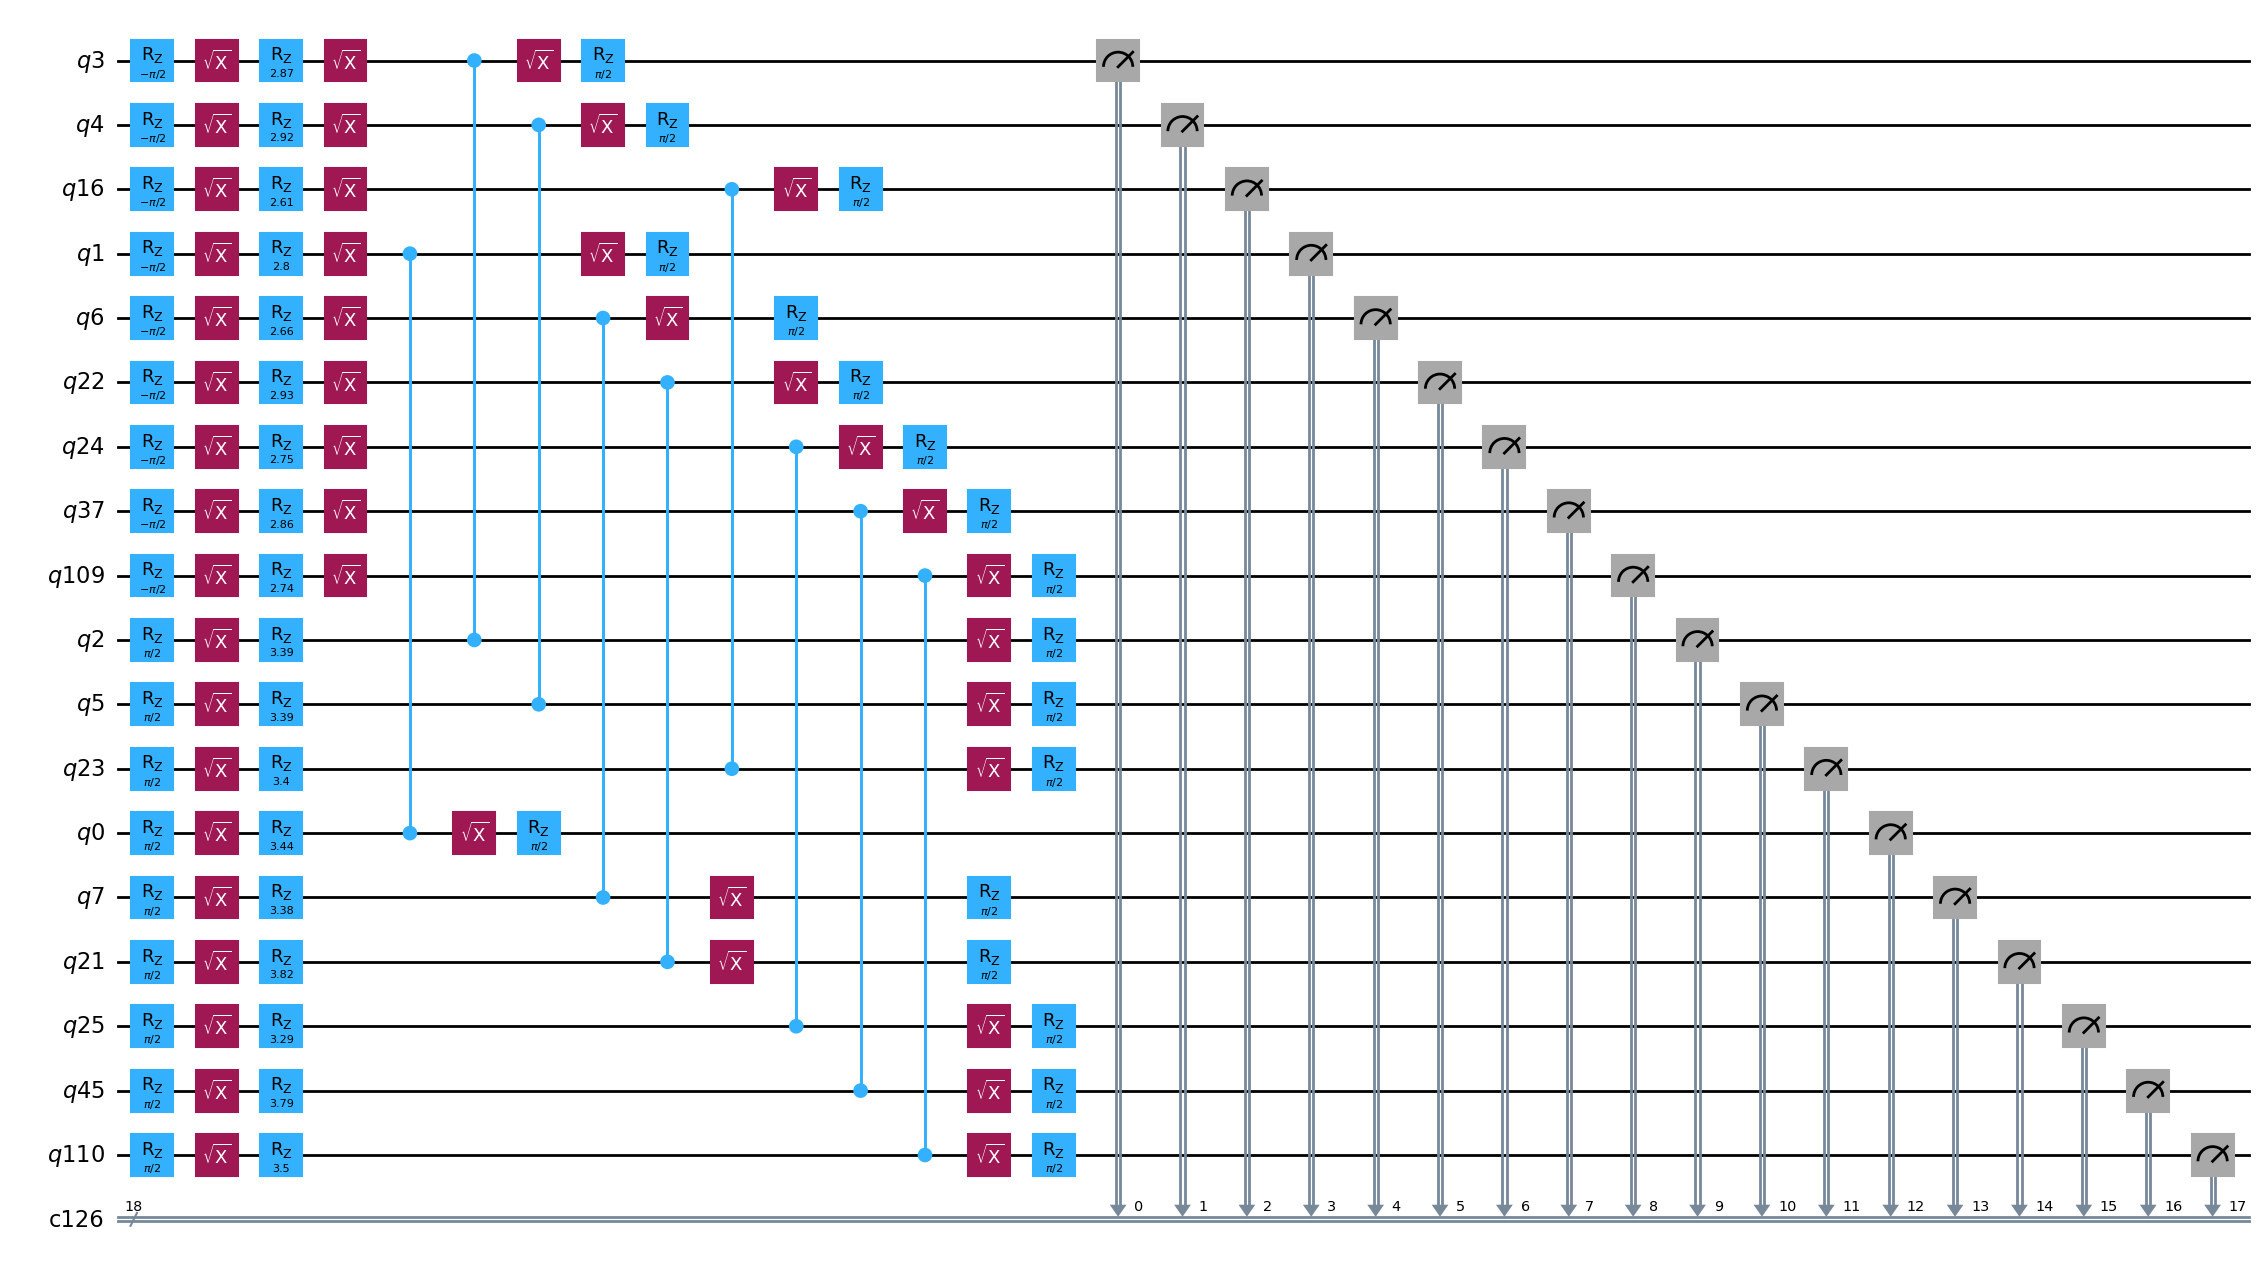

In [353]:
n = 'ang'
print(
    first_real_circuit[n].depth(),
    first_real_circuit[n].num_nonlocal_gates(),
)
first_real_circuit[n].trim().draw('mpl', fold=60)

285 68


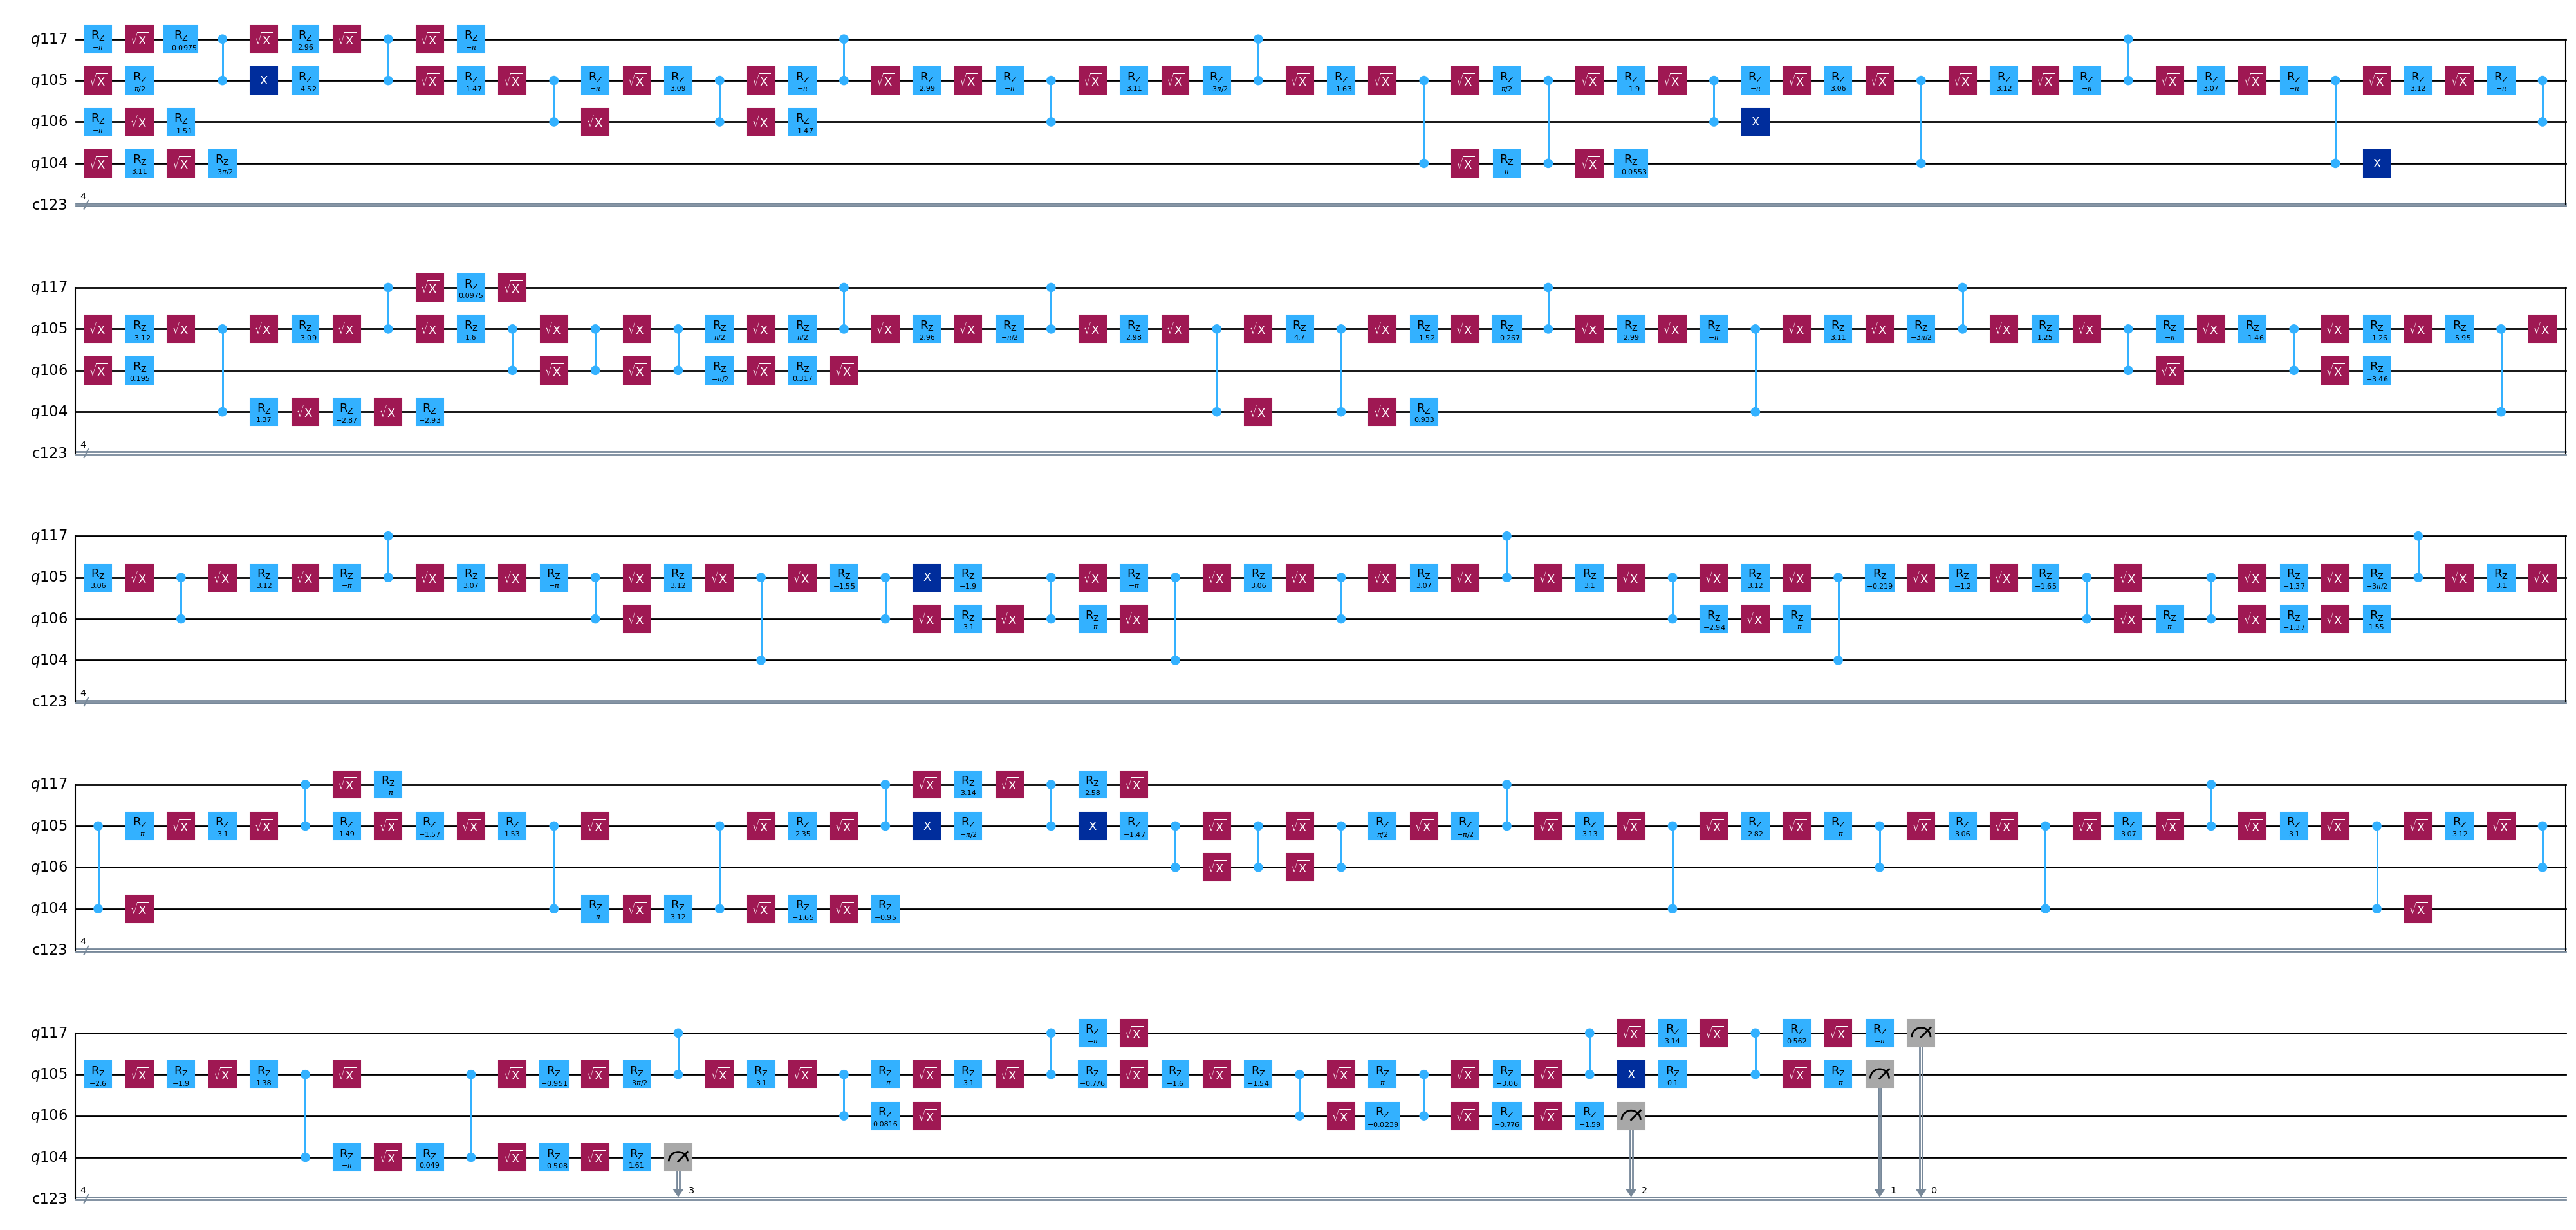

In [350]:
n = 'amp'
print(
    first_real_circuit[n].depth(),
    first_real_circuit[n].num_nonlocal_gates(),
)
first_real_circuit[n].trim().draw('mpl', fold=60)

407 110


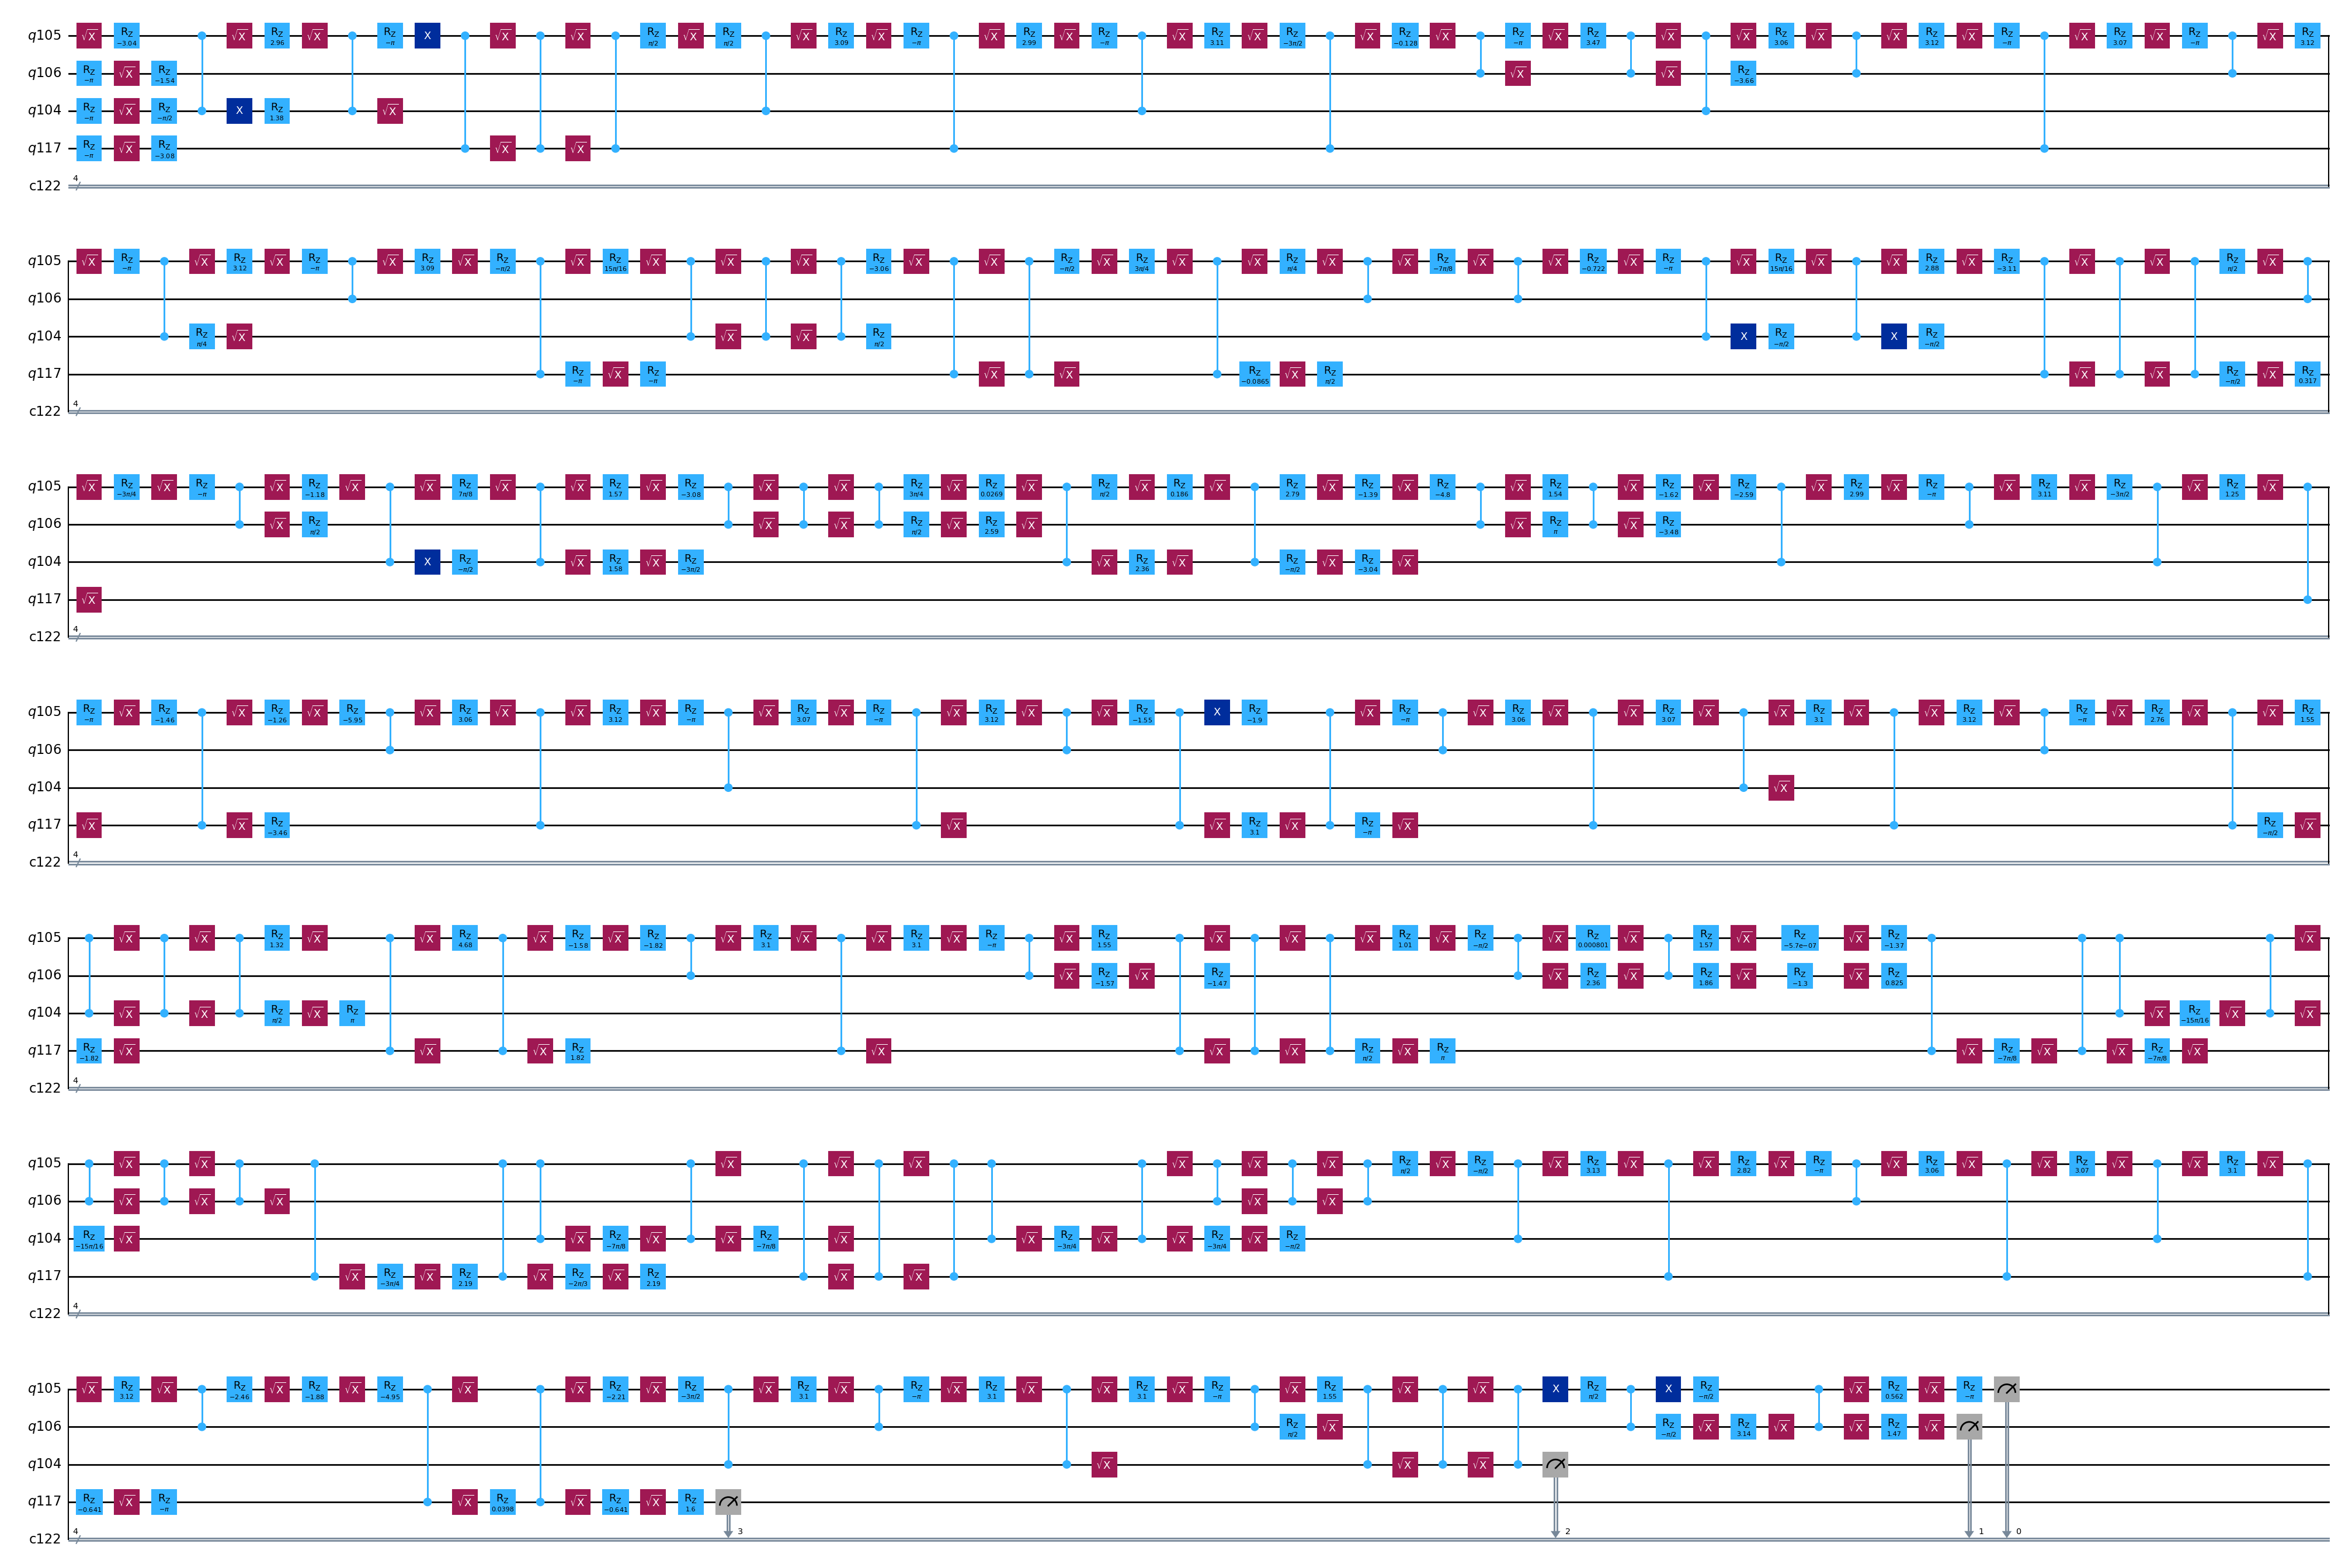

In [349]:
n = 'amp_qft'
print(
    first_real_circuit[n].depth(),
    first_real_circuit[n].num_nonlocal_gates(),
)
first_real_circuit[n].trim().draw('mpl', fold=60)

280 68


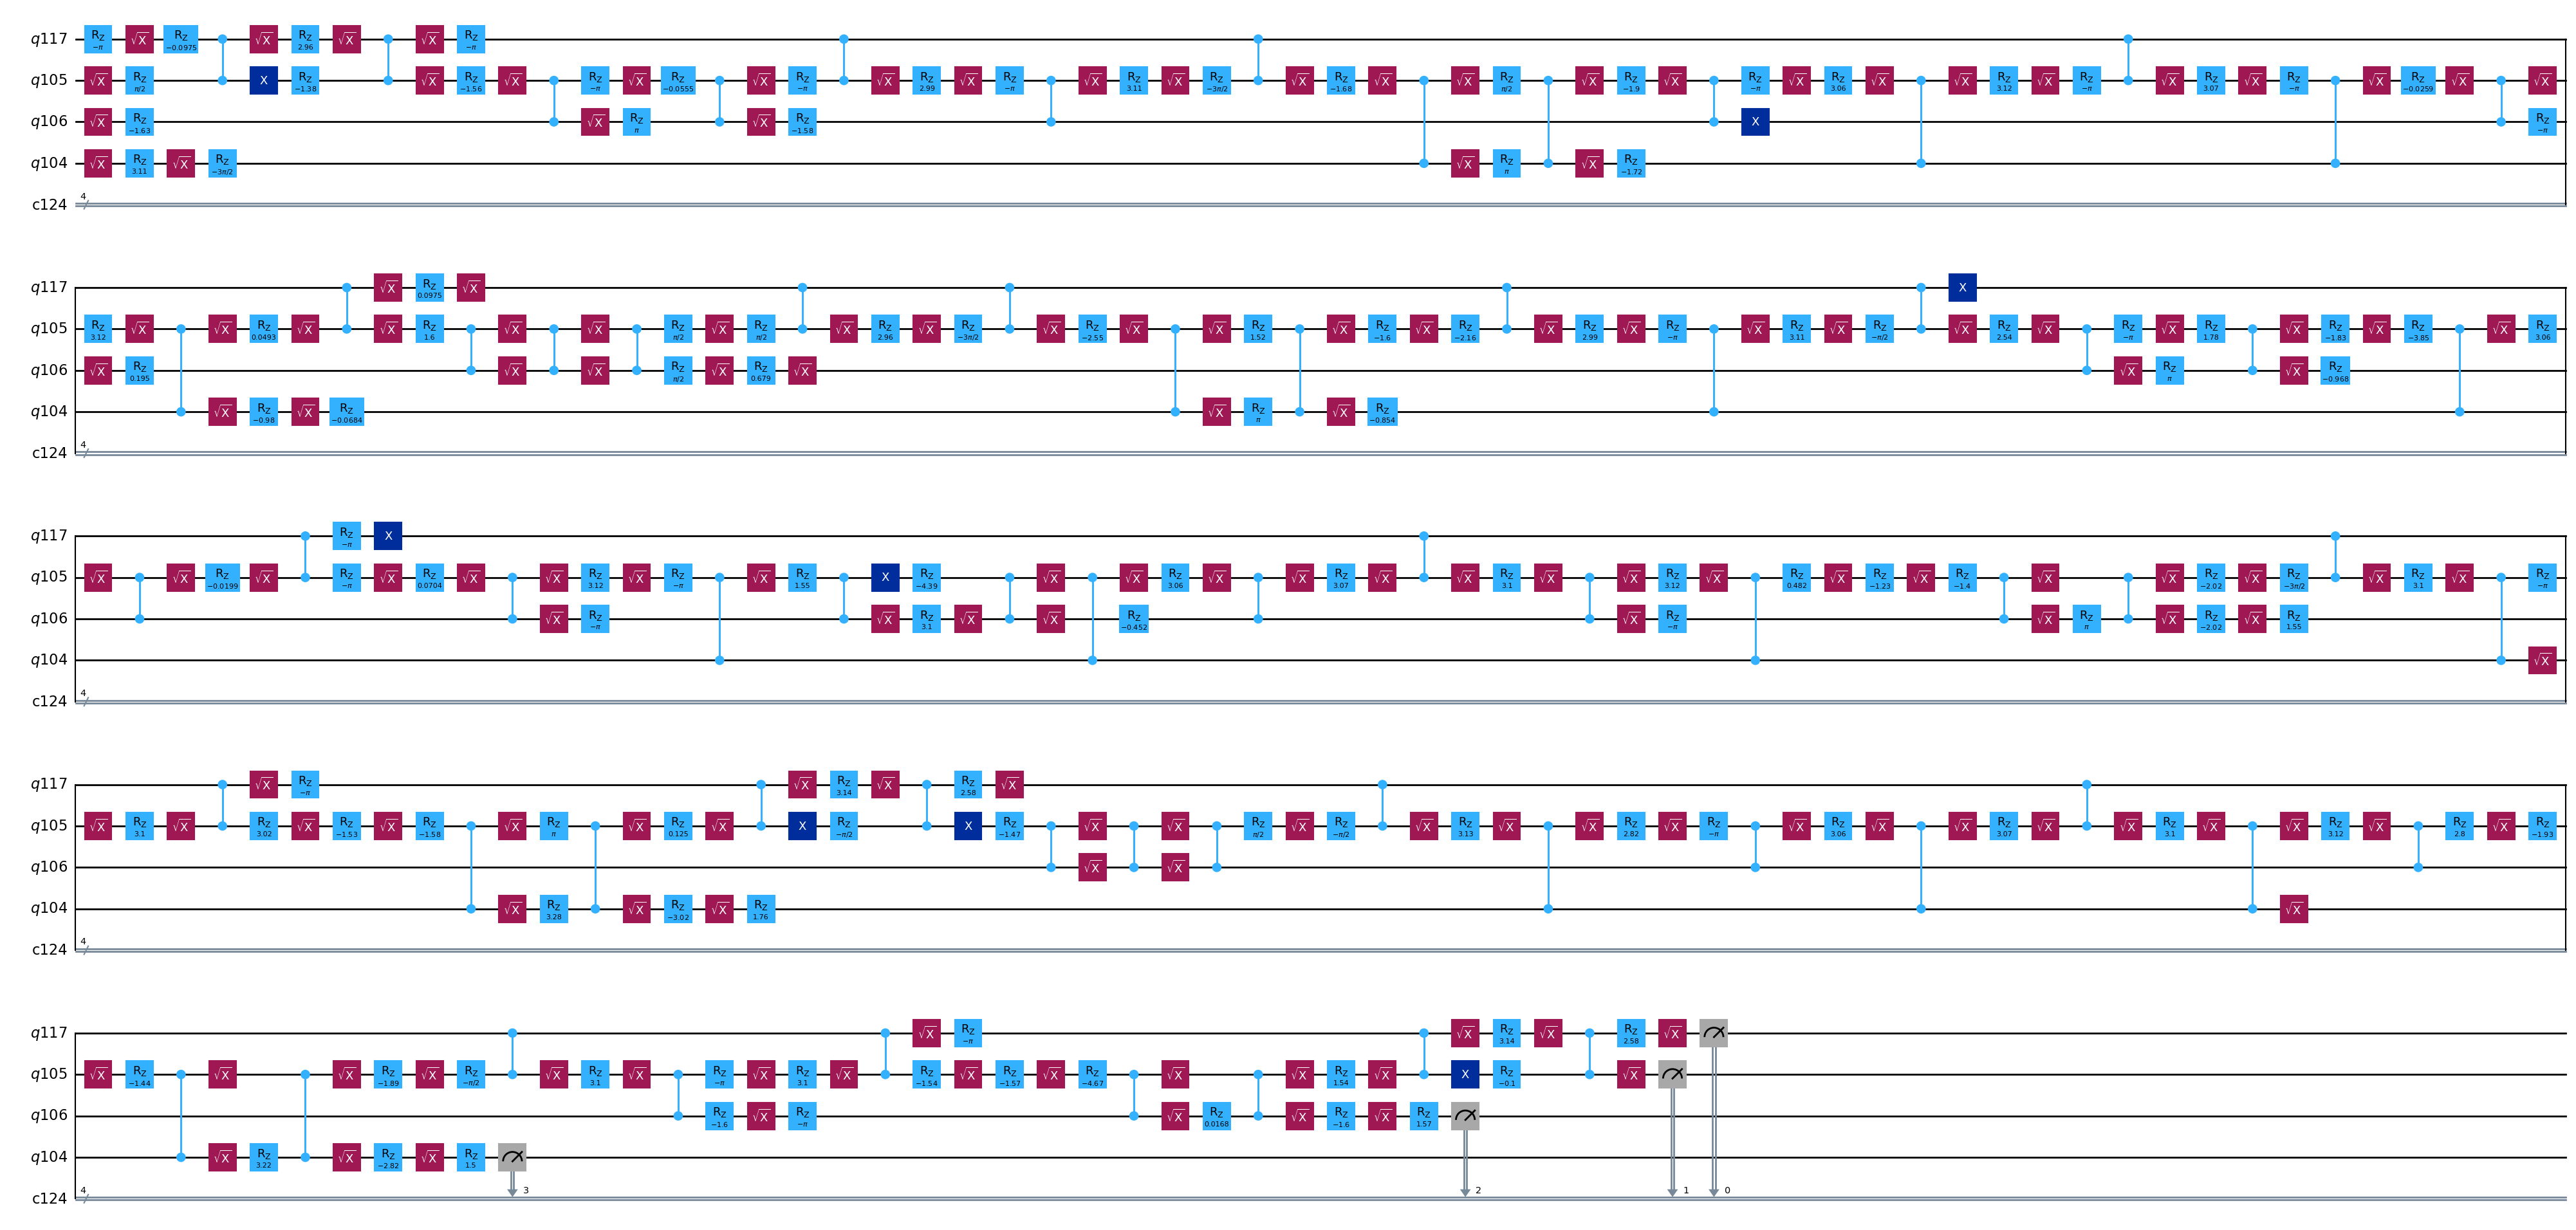

In [351]:
n = 'amp_ddd'
print(
    first_real_circuit[n].depth(),
    first_real_circuit[n].num_nonlocal_gates(),
)
first_real_circuit[n].trim().draw('mpl', fold=60)

401 108


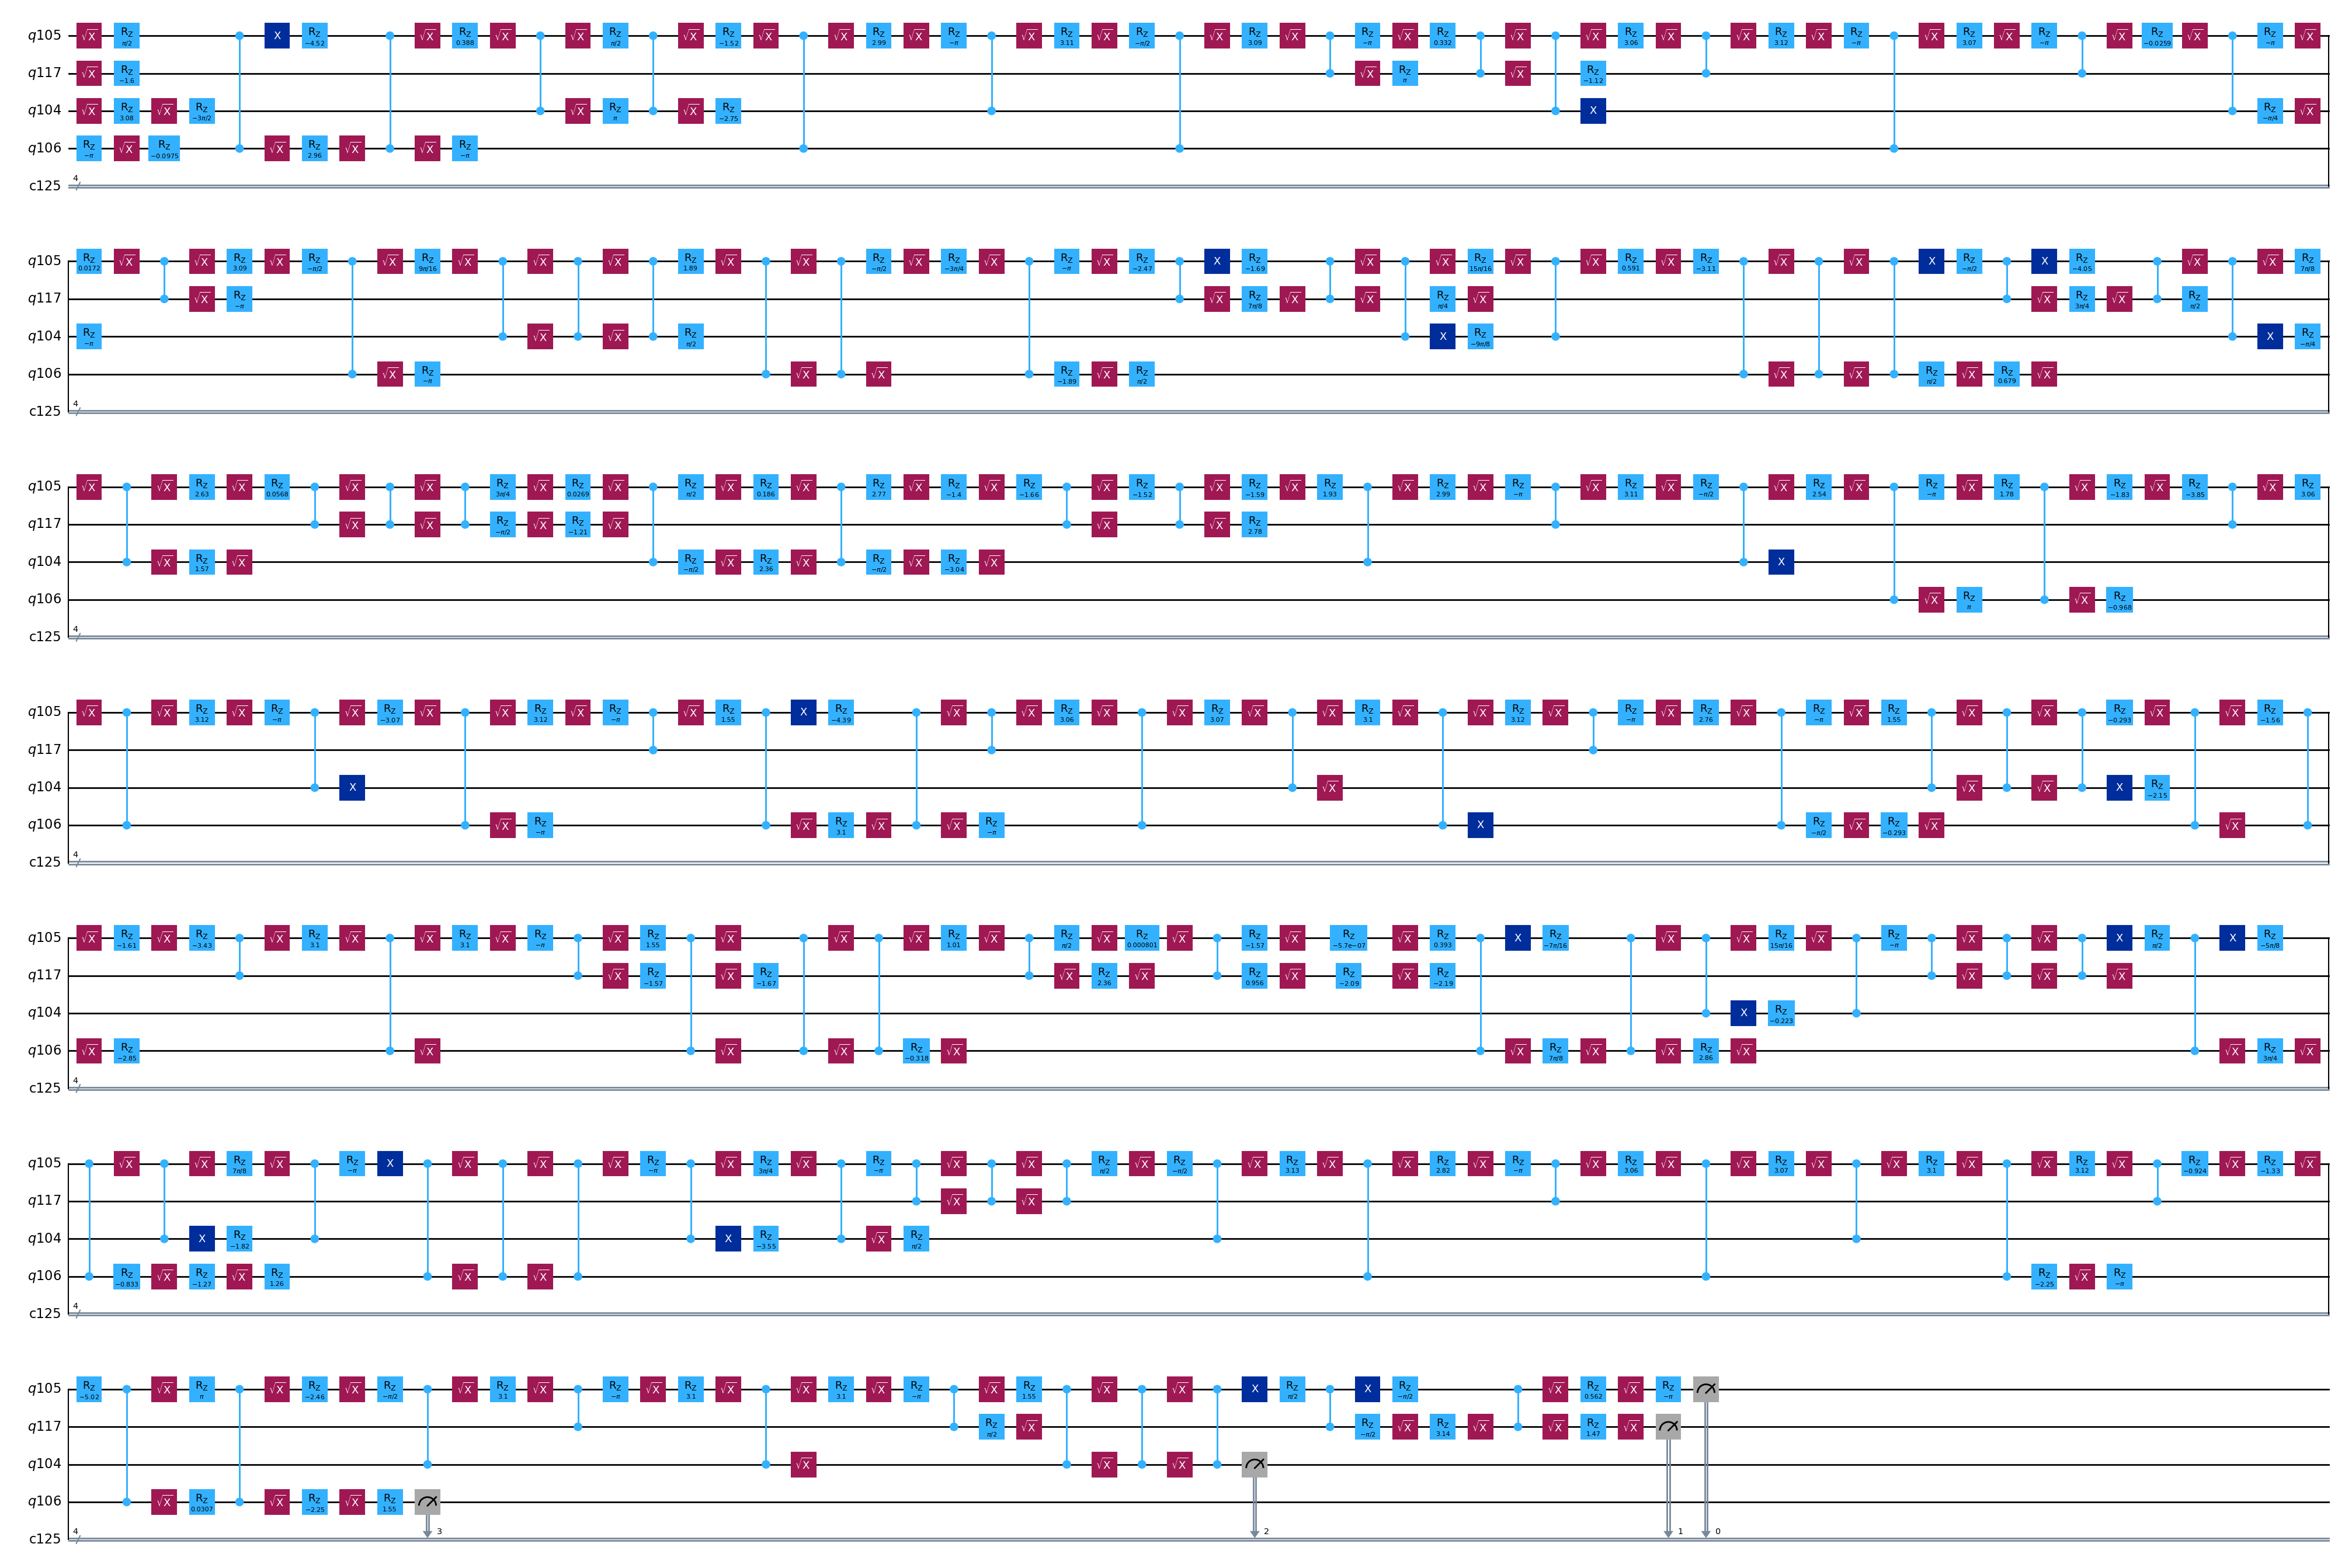

In [352]:
n = 'amp_qft_ddd'
print(
    first_real_circuit[n].depth(),
    first_real_circuit[n].num_nonlocal_gates(),
)
first_real_circuit[n].trim().draw('mpl', fold=60)